# nnUNet for custom dataset
# Table of contents
- [Introduction](#introduction)
- [Model](#model)
    - [Model creation](#model-creation)
    - [Metric](#metric)
- [Dataset](#dataset)
     - [Visualization](#visualization)
     - [Data loading](#dataloader)
- [Running the model on a custom dataset](#custom)
    - [Training](#training)
    - [Inference](#inference)

## Introduction <a name="introduction"></a>

In our repository nnUNet is used for [Medical Segmentation Decathlon](http://medicaldecathlon.com/) dataset. However, you can apply it to any dataset for the image segmentation task. In this notebook you will learn what parts of code needs to be changed to customize nnUNet.

For demonstration purposes we will use the satellite imagery from [xBD](https://arxiv.org/abs/1911.09296) dataset which was used at the [xView2](https://xview2.org) challenge. The goal of the contest was to build an accurate and efficient model for building localization and damage classification.  The xBD provides pre and post event satellite imagery across a variety of disaster events. The contests had two tasks corresponding to the image type:
- pre - localize buildings with 0, 1 segmentation mask.
- post - classify buildings damage with classes: 1, 2, 3, 4.

In this notebook we will focus on the building localization part i.e. pre disaster images.

To download the dataset you have to create an account at the [challenge website](https://xview2.org).

## Model <a name="model"></a>

The [nnUNet](https://arxiv.org/abs/1904.08128) refers to a robust and self-adapting framework for UNet based medical image segmentation. It allows segmenting 2D and 3D images with high accuracy and efficiency. 

Based on the dataset properties like image shapes and pixel spacings it dynamically creates UNet architecture by selecting a number of layers together with appropriate kernel sizes and strides. During data preprocessing we create *config.pkl* file with the metadata necessary for creating the UNet architecture. If the data preprocessing part is skipped the *config.pkl* file needs to be created manually. It contains dictionary with fields:

- `patch_size` - shape of cropped image during training
- `spacings` - pixel spacings
- `n_class` - number of classes
- `in_channels` - number of input channels

In [1]:
import os
import pickle

PATH = "/data/11_2d"

pickle.dump(
    {
        "patch_size": [512, 512],
        "spacings": [1, 1],
        "n_class": 2,
        "in_channels": 3,
    },
    open(os.path.join(PATH, "config.pkl"), "wb"),
)

### Model creation <a name="model-creation"></a>

Normally, we pass model parameters as command line arguments for `main.py` script, when running nnUNet in jupyter notebook you can pass them as a string to `get_main_args` function which returns the *Namespace* necessary to initialize the model.

In this examples the parameters are `--task 11 --dim 2 --deep_supervision --data2d_dim 2 --tta --norm batch`, where:
- `task` - number of task to run (tasks 01-10 are reserved for MSD). The full path to data location is inferred from it by: /data/{task}_{dim}d
- `dim` - dimensionality of UNet
- `data2d_dim` - dimensionality of input data from data loader. (For MSD tasks we get 3D data from data loaders also for 2D UNet and transform its layout before feeding it to the network)
- `deep_supervision` - enables deep supervision
- `tta` - enables test time augmentation
- `norm` - normalization layer (by default instance normalization is used)

For full list of command line arguments parameter see [here](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Segmentation/nnUNet#command-line-options).

In [2]:
import sys; sys.path.append("../")
from models.nn_unet import NNUnet
from utils.utils import get_main_args

params = "--task 11 --dim 2 --deep_supervision --data2d_dim 2 --tta --norm batch"
args = get_main_args(params)
model = NNUnet(args)

### Metric <a name="metric"></a>

It is possible to customize your metrics as well. In our nnUNet repo we use the mean dice as the final metric. However, in xView2 global F1 score were used. Below we provide implementation of global F1 score and are overriding the model metric with custom f1 score.

In [3]:
from pytorch_lightning.metrics import Metric
import torch
import torch.nn as nn

class F1(Metric):
    def __init__(self):
        super().__init__(dist_sync_on_step=False)
        self.add_state("tp", default=torch.zeros((1,)), dist_reduce_fx="sum")
        self.add_state("fp", default=torch.zeros((1,)), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.zeros((1,)), dist_reduce_fx="sum")

    def update(self, preds, targets):
        preds = torch.argmax(preds, dim=1)
        true_pos, false_neg, false_pos = self.get_stats(preds, targets, 1)
        self.tp[0] += true_pos
        self.fn[0] += false_neg
        self.fp[0] += false_pos

    def compute(self):
        return 200 * self.tp / (2 * self.tp + self.fp + self.fn)

    @staticmethod
    def get_stats(pred, targ, class_idx):
        true_pos = torch.logical_and(pred == class_idx, targ == class_idx).sum()
        false_neg = torch.logical_and(pred != class_idx, targ == class_idx).sum()
        false_pos = torch.logical_and(pred == class_idx, targ != class_idx).sum()
        return true_pos, false_neg, false_pos
    
f1_score = F1()
model.dice = f1_score

## Dataset <a name="dataset"></a>

The xBD is the largest building damage assessment dataset to date, containing 850.736 building annotations across 45.362 km2 of imagery. There are 9168 and 933 images in the training and validation set respectively where each image has shape (1024, 1024, 3).


In this notebook we assume the dataset has the following structure:

```
/data/11_2d 
 │
 ├───train
 │      ├── images 
 │      │      └── <image_id>.png
 │      │      └── ...
 │      └── targets
 │             └── <image_id>.png
 │             └── ...
 └────val
        ├── images 
        │      └── <image_id>.png
        │      └── ...
        └── targets
               └── <image_id>.png
               └── ...
```

### Visualization <a name="visualization"></a>

Let's start with visualization of some images and their corresponding labels.

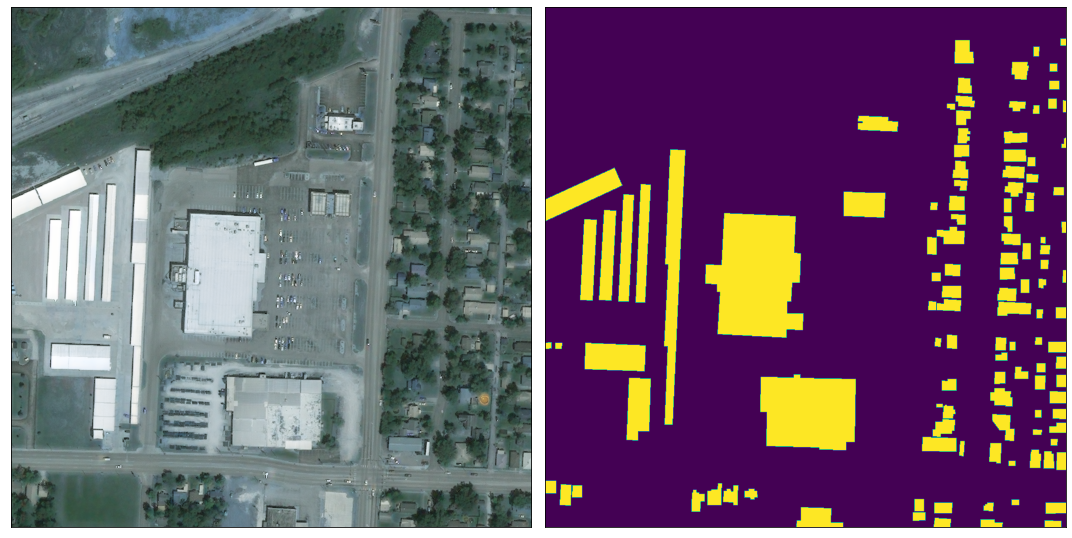

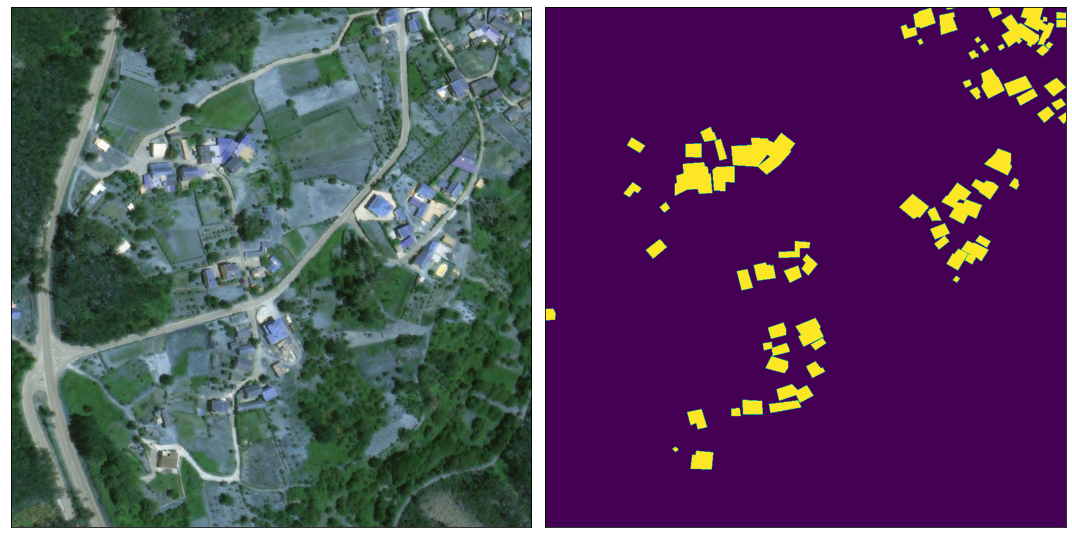

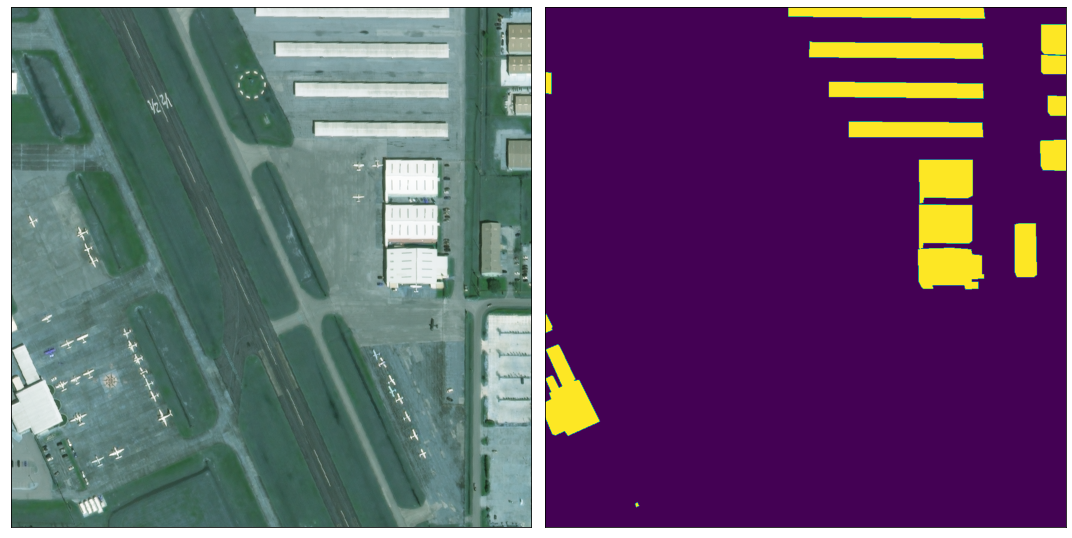

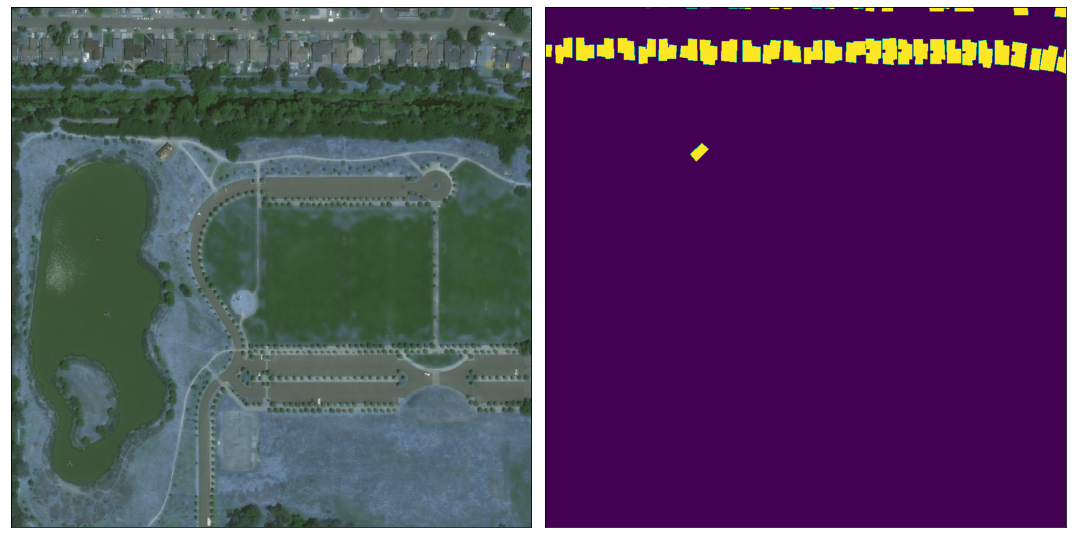

In [4]:
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Loading pre images which correspond to localization task.
imgs = sorted(glob(os.path.join(PATH, "train", "images", f"*pre*"))) 
lbls = sorted(glob(os.path.join(PATH, "train", "targets", f"*pre*")))

for idx in [1385, 5560, 408, 6897]:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    c1, c2 = ax
    img, lbl = cv2.imread(imgs[idx]), cv2.imread(lbls[idx], cv2.IMREAD_UNCHANGED)
    for c, p in [(c1, img), (c2, lbl)]:
        c.axes.xaxis.set_visible(False)
        c.axes.yaxis.set_visible(False)
        c.imshow(p)
    fig.tight_layout()
plt.show()

### Data loading <a name="dataloader"></a>

In our nnUNet repository we are converting data to npy format and use [NVIDIA DALI](https://docs.nvidia.com/deeplearning/dali/master-user-guide/docs/index.html) for data loading. However, you can modify this part and create your own data loading pipeline.

In this example we use PyTorch DataLoader with *zoom*, *crop*, *flips*, *gaussian noise*, *gamma*, *brightness* and *contrast* for data augmentation from [albumentations](https://albumentations.ai) library.

As our implementation of nnUNet is based on [PyTorch-Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) we need to create *LightningDataModule* to wrap the data loaders.

In [5]:
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningDataModule
import albumentations as A
import numpy as np

class xBDTrainDataset(Dataset):
    def __init__(self, path):
        self.imgs = sorted(glob(os.path.join(path, "images", f"*pre*")))
        self.lbls = sorted(glob(os.path.join(path, "targets", f"*pre*"))) 
        assert len(self.imgs) == len(self.lbls)
        self.zoom = A.RandomScale(p=0.2, scale_limit=(0, 0.3), interpolation=cv2.INTER_CUBIC)
        self.crop = A.CropNonEmptyMaskIfExists(p=1, width=512, height=512)
        self.hflip = A.HorizontalFlip(p=0.33)
        self.vflip = A.VerticalFlip(p=0.33)
        self.noise = A.GaussNoise(p=0.1)
        self.brctr = A.RandomBrightnessContrast(p=0.2)
        self.gamma = A.RandomGamma(p=0.2)
        self.normalize = A.Normalize()

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img, lbl = self.load_pair(idx)
        data = {"image": img, "mask": lbl}
        data = self.zoom(image=data["image"], mask=data["mask"])
        data = self.crop(image=data["image"], mask=data["mask"])
        data = self.hflip(image=data["image"], mask=data["mask"])
        data = self.vflip(image=data["image"], mask=data["mask"])
        img, lbl = data["image"], data["mask"]
        img = self.noise(image=img)["image"]
        img = self.brctr(image=img)["image"]
        img = self.gamma(image=img)["image"]
        img = self.normalize(image=img)["image"]
        lbl = np.expand_dims(lbl, 0)
        return {"image": np.transpose(img, (2, 0, 1)), "label": lbl}
    
    def load_pair(self, idx):
        img = cv2.imread(self.imgs[idx])
        lbl = cv2.imread(self.lbls[idx], cv2.IMREAD_UNCHANGED)
        return img, lbl
    
class xBDValDataset(Dataset):
    def __init__(self, path):
        self.imgs = sorted(glob(os.path.join(path, "images", f"*pre*")))
        self.lbls = sorted(glob(os.path.join(path, "targets", f"*pre*"))) 
        assert len(self.imgs) == len(self.lbls)
        self.normalize = A.Normalize()

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img, lbl = self.load_pair(idx)
        img = self.normalize(image=img)["image"]
        lbl = np.expand_dims(lbl, 0)
        return {"image": np.transpose(img, (2, 0, 1)), "label": lbl}
    
    def load_pair(self, idx):
        img = cv2.imread(self.imgs[idx])
        lbl = cv2.imread(self.lbls[idx], cv2.IMREAD_UNCHANGED)
        return img, lbl   
    
class DataModule(LightningDataModule):
    def __init__(self, data_path, batch_size):
        super().__init__()
        self.data_path = data_path
        self.train_dataset = xBDTrainDataset(os.path.join(self.data_path, "train"))
        self.val_dataset = xBDValDataset(os.path.join(self.data_path, "val"))
        self.loader_kwargs = {
            "batch_size": batch_size,
            "pin_memory": True,
            "num_workers": 8,
        }

    def train_dataloader(self):
        return DataLoader(self.train_dataset, drop_last=True, shuffle=True, **self.loader_kwargs)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, **self.loader_kwargs)
                                   
data_module = DataModule("/data/11_2d", batch_size=32)

## Running the model on a custom dataset <a name="custom"></a>

Now we are all set to start training nnUNet on xBD dataset.

### Training <a name="training"></a>

Thanks to PyTorch Lightning we can very easily train with AMP or multigpu - just pass *precision=16* and *gpus=NGPU* to the lightning Trainer.

In [6]:
from pytorch_lightning import Trainer

trainer = Trainer(
    gpus=1,
    precision=16,
    benchmark=True,
    max_epochs=350,
    num_sanity_val_steps=0,
    progress_bar_refresh_rate=0,
    default_root_dir=args.results,
)
trainer.fit(model, data_module);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 20 M  
1 | loss  | Loss | 0     
2 | dice  | F1   | 0     


DLL 2021-01-27 15:55:11.651972 - Epoch: 2  mean dice : 26.95  TOP_mean : 31.92  L1 : 26.95  TOP_L1 : 31.92  val_loss : 1.6896 
DLL 2021-01-27 15:55:43.790388 - Epoch: 3  mean dice : 35.08  TOP_mean : 35.08  L1 : 35.08  TOP_L1 : 35.08  val_loss : 1.4001 
DLL 2021-01-27 15:56:16.278869 - Epoch: 4  mean dice : 51.94  TOP_mean : 51.94  L1 : 51.94  TOP_L1 : 51.94  val_loss : 1.1878 
DLL 2021-01-27 15:56:49.061071 - Epoch: 5  mean dice : 43.85  TOP_mean : 51.94  L1 : 43.85  TOP_L1 : 51.94  val_loss : 1.6676 
DLL 2021-01-27 15:57:21.398056 - Epoch: 6  mean dice : 58.42  TOP_mean : 58.42  L1 : 58.42  TOP_L1 : 58.42  val_loss : 1.0467 
DLL 2021-01-27 15:57:53.967409 - Epoch: 7  mean dice : 61.0  TOP_mean : 61.0  L1 : 61.0  TOP_L1 : 61.0  val_loss : 0.9772 
DLL 2021-01-27 15:58:27.051273 - Epoch: 8  mean dice : 66.7  TOP_mean : 66.7  L1 : 66.7  TOP_L1 : 66.7  val_loss : 0.8786 
DLL 2021-01-27 15:58:59.420432 - Epoch: 9  mean dice : 62.74  TOP_mean : 66.7  L1 : 62.74  TOP_L1 : 66.7  val_loss : 0.

### Inference <a name="inference"></a>

As a final step lets run an inference and visualize the predicted masks from trained nnUNet.

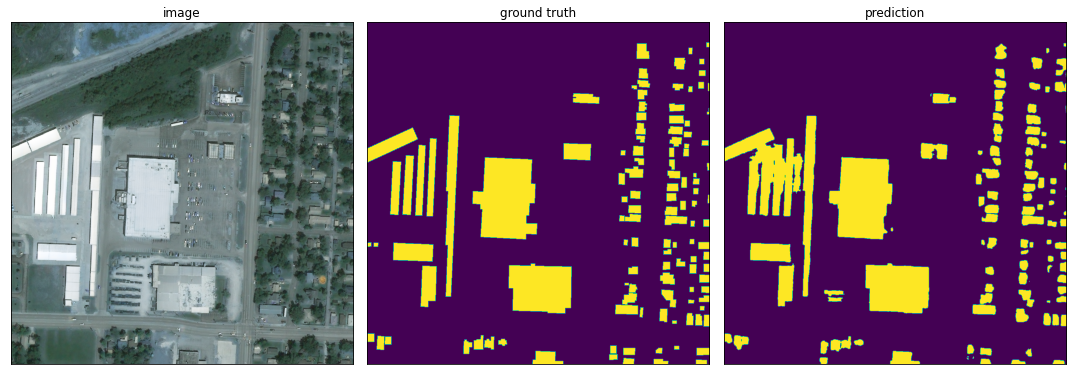

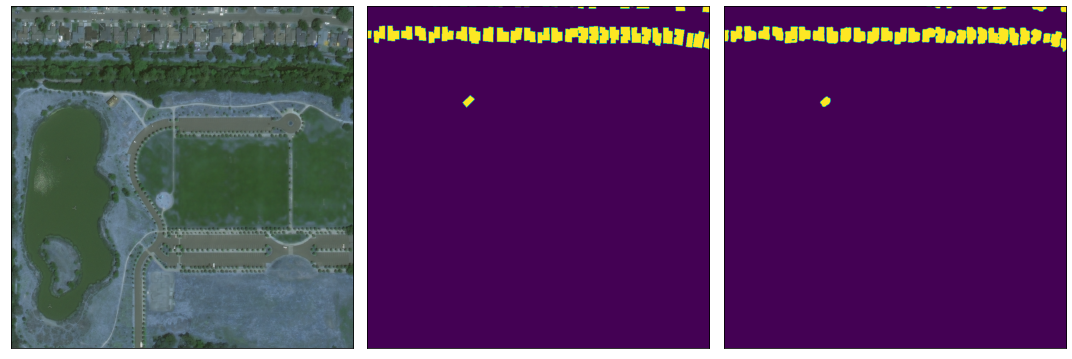

In [7]:
model = NNUnet.load_from_checkpoint("/results/checkpoints/last.ckpt", strict=False, map_location={"cuda:0": "cpu"})
normalize = A.Normalize()
idx = [1385, 6897]
im, lb = [], []
for i in idx:
    img = np.transpose(normalize(image=cv2.imread(imgs[i]))["image"], (2, 0, 1))
    im.append(torch.tensor(img))
    lb.append(cv2.imread(lbls[i], cv2.IMREAD_UNCHANGED))
    
img = torch.tensor(np.stack(im))
model = model.eval()
out = model(img)
preds = np.argmax(out.detach().numpy(), 1)

for i in range(2):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    c1, c2, c3 = ax
    img, pred, lbl = cv2.imread(imgs[idx[i]]), preds[i], lb[i]
    for a, (c, p) in enumerate([(c1, img), (c2, lbl), (c3, pred)]):
        c.axes.xaxis.set_visible(False)
        c.axes.yaxis.set_visible(False)
        if i == 0:
            c.title.set_text(["image", "ground truth", "prediction"][a])
        c.imshow(p)
    fig.tight_layout()
plt.show()